In [3]:
from collections import defaultdict
%load_ext autoreload
from dotenv import load_dotenv

load_dotenv('.env.telia')
%autoreload 2

In [24]:
from src.utils import saveToFile, fileContentsFromFolder, readFileContents
from src.utils import readFile
from collections import Counter
import json
import re
from wordcloud import WordCloud

In [4]:
basePath = '../data/telia/measurements/fragmentSeries/'

In [5]:
with open('../data/telia/c8y_data.json', 'r', encoding='utf8') as json_file:
    c8y_data = json.load(json_file)

deviceIdMapping = {device['id']: device for device in c8y_data}

In [26]:
def fixFragmentName(name):
    match = re.match("^(sensor)_\\d{1,4}(.*)", name)  # sensor_1235_daily -> sensor_daily
    if match:
        return match.group(1) + match.group(2)
    return name

In [57]:
def mapUniqueValues(uniqueValues, fileContents):
    for device in fileContents:
        deviceId = device['deviceId']
        deviceName = deviceIdMapping[deviceId]['name']
        deviceType = device['deviceType']
        
        for fragmentSeries in device['typeFragmentSeries']:
            measurement = fragmentSeries['measurement']
    
            if measurement:
                measurementType = fragmentSeries['type']
                fragment = fragmentSeries['fragment']
                series = fragmentSeries['series']
                measurementValue = measurement[fragment][series]
                fragment = fixFragmentName(fragment)
                unit = measurementValue['unit'] if 'unit' in measurementValue else ''
                value = str(measurementValue['value']) if 'value' in measurementValue else ''
                
                values = ['' if value is None else value for value in [deviceId, deviceName, deviceType, measurementType, fragment, series, unit, value]]
                uniqueValues.add(tuple(values))  

In [59]:
def formatMeasurementData(uniqueValues):
    result = {}
    for deviceId, device_name, device_type, measurement_type, fragment, series, unit, value in uniqueValues:
        if deviceId in result:
            value = result[deviceId]
            if fragment not in value:
                value[fragment] = {}
            if series not in value[fragment]:
                value[fragment][series] = unit
        else:
            result[deviceId] = {
                "device": device_name,
                "type": device_type,
                fragment : {
                    series : {
                        "unit": unit,
                        "value":value
                    }
                }
            }
    return result

In [55]:
fileContents = readFile("telia/measurements/typeFragmentSeries/c8y_measurements 2024-03-01 - 2024-04-01.json")
Counter([sum([fragment['count'] for fragment in device['typeFragmentSeries']]) > 0 for device in b])

Counter({False: 14938, True: 4324})

In [58]:
uniqueValues = set()
mapUniqueValues(uniqueValues, fileContents)
len(uniqueValues)

19294

In [60]:
result = formatMeasurementData(uniqueValues)
len(result)

4324

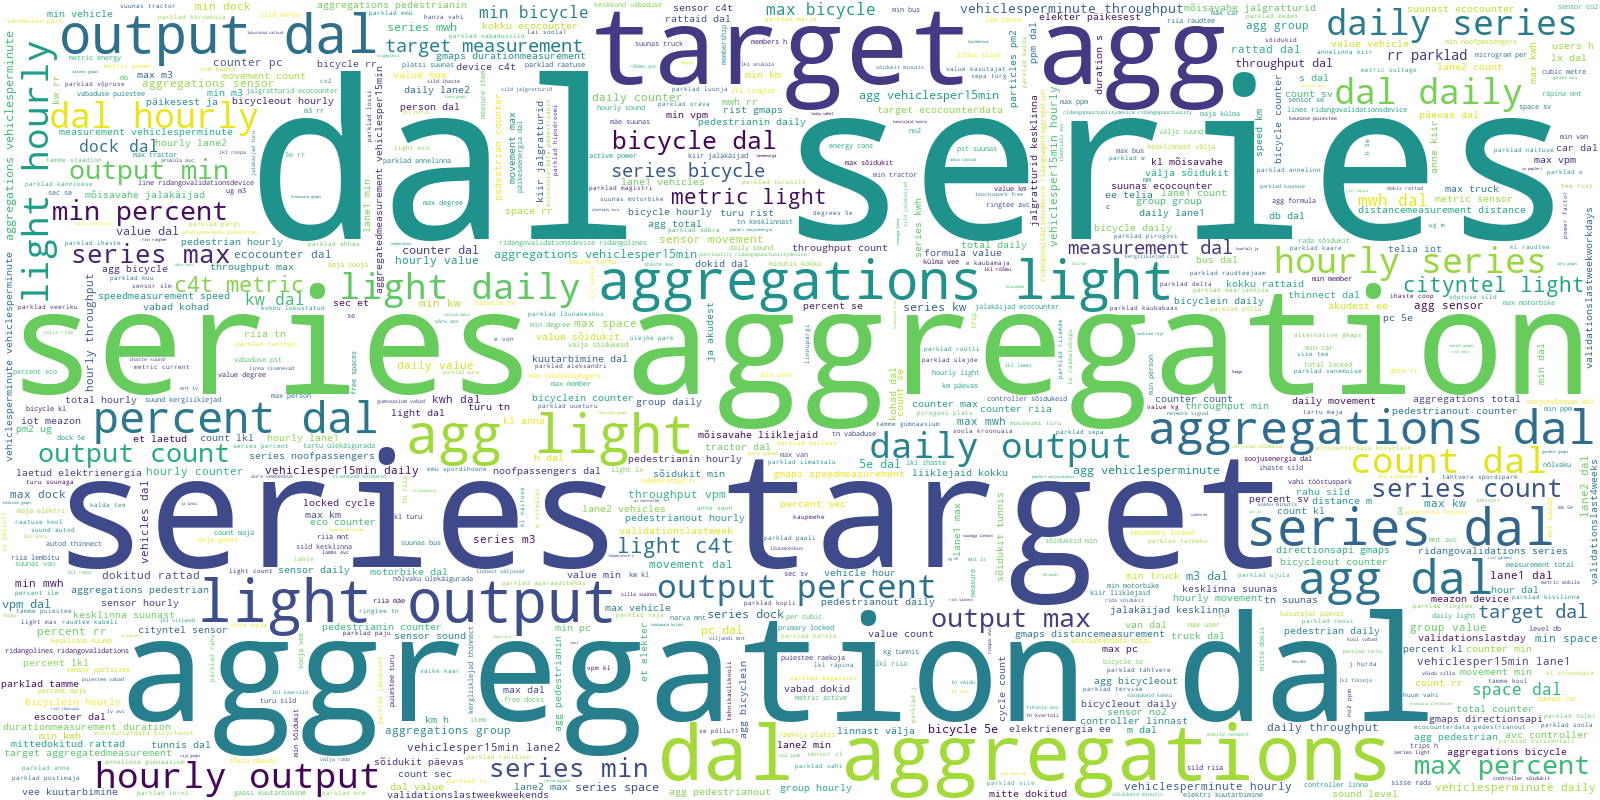

In [50]:
# data_combined = ', '.join([' '.join(value[1:]) for value in list(c)]).lower().replace("_", ' ')
# data_combined = ','.join([str(value).lower().replace("_", ' ').replace("'", '') for value in result.values()])
data_combined = ','.join([','.join(value[1:]) for value in uniqueValues]).lower().replace("_", ' ').replace("'", '')
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=1600, height=800)
# Generate a word cloud
wordcloud.generate(data_combined)
# Visualize the word cloud
wordcloud.to_file('measurements wordcloud.png')
wordcloud.to_image()